# Central RL control notebook

In [1]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython.display import display,clear_output
import pandas as pd
from Storage import StorageSuite as st
from pathlib import Path
from math import e
from time import sleep
from DQNEnv import DQAgent
import pickle as pkl

Time span constants

In [2]:
YEAR = 31579200
MONTH = 2570400
WEEK = 604800
DAY = 86400
HOUR = 3600
MINUTE = 60

### Generate Microgrids

In [3]:
n_grids = 2
grid_list = []

for i in range(n_grids):
    loaderino = np.random.randint(1E5,6E5)
    grid_list.append(st(r'C:\Users\thesu\Desktop\Research 2022 Microgrid\Research code repository\Micro-Grid-ML-algo\data\dummy_data_v1.csv',load=loaderino))
mg_env = mg.MicrogridGenerator(storage_suite_list=grid_list)
mg_env.generate_microgrid(verbose= True, interpolate= True)

46578.933333333334
25036.176666666666
139736.8
{'li-ion': <Storage.Storage object at 0x0000025893A23D60>, 'flywheel': <Storage.Storage object at 0x0000025893A23E80>, 'flow': <Storage.Storage object at 0x0000025804651F30>}
50382.53333333333
27080.611666666664
151147.59999999998
{'li-ion': <Storage.Storage object at 0x00000258045EE380>, 'flywheel': <Storage.Storage object at 0x00000258045EF550>, 'flow': <Storage.Storage object at 0x00000258045EFDF0>}


,load,load_size,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,grid_weak,grid_power_import,grid_power_export,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,349342,349342,10,1,0.1,216592.04,0,698684,698684,3,8.962852,0.699991,0.07143,388158,0.05,0.9,0.4,2


,load,load_size,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,grid_weak,grid_power_import,grid_power_export,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,377869,377869,10,1,0.1,294737.82,1,755738,755738,3,1.897018,0.255098,0.031388,419855,0.05,0.9,0.4,2


,load,load_size,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,grid_weak,grid_power_import,grid_power_export,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,349342,349342,10,1,0.1,216592.04,0,698684,698684,3,8.962852,0.699991,0.071430,388158,0.05,0.9,0.4,2
1,377869,377869,10,1,0.1,294737.82,1,755738,755738,3,1.897018,0.255098,0.031388,419855,0.05,0.9,0.4,2


In [4]:
mg0 = mg_env.microgrids[0]
mg1 = mg_env.microgrids[1]

In [5]:
mg_env.print_mg_parameters()

,load,load_size,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,grid_weak,grid_power_import,grid_power_export,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,349342,349342,10,1,0.1,216592.04,0,698684,698684,3,8.962852,0.699991,0.071430,388158,0.05,0.9,0.4,2
1,377869,377869,10,1,0.1,294737.82,1,755738,755738,3,1.897018,0.255098,0.031388,419855,0.05,0.9,0.4,2


In [20]:
# control_dict = {            'pv_consummed': min(pv,load),
#                             'li_charge': 0,
#                             'li_discharge': 0,
#                             'flow_charge': 0,
#                             'flow_discharge': 0,
#                             'flywheel_charge': 0,
#                             'flywheel_discharge': 0,
#                             'grid_import': 0,
#                             'grid_export':0,
#                             'genset': 0
#                            }

def actions_agent(mg0, action):
    li_ion,flow,flywheel = mg0.ss.unpack()
    pv =                            round(mg0.pv)
    load =                          round(mg0.load)
    net_load =                      load-pv
    status =                        mg0.grid.status
    # overgen_net_load =            pv-load
    li_ion_capa_to_charge =         li_ion.capa_to_charge
    li_ion_capa_to_discharge =      li_ion.capa_to_discharge
    flow_capa_to_charge =           flow.capa_to_charge
    flow_capa_to_discharge =        flow.capa_to_discharge
    flywheel_capa_to_charge =       flywheel.capa_to_charge
    flywheel_capa_to_discharge =    flywheel.capa_to_discharge

    li_ion_charge =                 max(0,min(-net_load,li_ion_capa_to_charge ,li_ion.power))
    li_ion_discharge =              max(0,min(net_load,li_ion_capa_to_discharge,li_ion.power))

    flow_charge =                   max(0,min(-net_load,flow_capa_to_charge ,flow.power))
    flow_discharge =                max(0,min(net_load,flow_capa_to_discharge,flow.power))

    flywheel_charge=                max(0,min(-net_load,flywheel_capa_to_charge ,flywheel.power))
    flywheel_discharge =            max(0,min(net_load,flywheel_capa_to_discharge,flywheel.power))
    
    # li_ion_soc =                 abs(li_ion.soc)
    # flow_soc =                   abs(flow.soc)
    # flywheel_soc =               abs(flywheel.soc)
    
    # soc_list = {'li_ion_soc': li_ion_soc, 'flow_soc': flow_soc, 'flywheel_soc': flywheel_soc}
    # soc_list = sorted(soc_list, key=lambda x: (soc_list[x]))
    
    if action == 0:
        # CHARGE LI-ION
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': li_ion_charge,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': 0,
                            'flywheel_charge': 0,
                            'flywheel_discharge': 0,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
    if action == 1:
        # DISCHARGE LI-ION
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': li_ion_discharge,
                            'flywheel_charge': 0,
                            'flywheel_discharge': 0,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
 ######################
    if action == 2:
        # CHARGE FLOW
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': flow_charge,
                            'flow_discharge': 0,
                            'flywheel_charge': 0,
                            'flywheel_discharge': 0,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
    if action == 3:
        # DISCHARGE FLOW
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': flow_discharge,
                            'flywheel_charge': 0,
                            'flywheel_discharge': 0,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
 ######################
    if action == 4:
        # CHARGE FLYWHEEL
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': 0,
                            'flywheel_charge': flywheel_charge,
                            'flywheel_discharge': 0,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
    if action == 5:
        # DISCHARGE FLYWHEEL
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': 0,
                            'flywheel_charge': 0,
                            'flywheel_discharge': flywheel_discharge,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
 ######################
    if action == 6:
        # IMPORT
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': 0,
                            'flywheel_charge': 0,
                            'flywheel_discharge': 0,
                            'grid_import': abs(net_load)*status,
                            'grid_export': 0,
                            'genset': 0
                        }
    if action == 7:
        # EXPORT
        control_dict = {    'pv_consummed': min(pv,load),
                            'li_charge': 0,
                            'li_discharge': 0,
                            'flow_charge': 0,
                            'flow_discharge': 0,
                            'flywheel_charge': 0,
                            'flywheel_discharge': 0,
                            'grid_import': 0,
                            'grid_export': abs(net_load)*status,
                            'genset': 0
                        }
        
    return control_dict


   

In [21]:
# def change_name_action(idx):
# # Grid is up
#     if idx == 0:
#         action_name = "NON-ISLANDED OVERGENERATION EXPORT"
#     elif idx == 1:
#         action_name = "NON-ISLANDED OVERGENERATION EXCLUSIVE CHARGE AND EXPORT"
#     elif idx == 2:
#         action_name = "ISLANDED OVERGENERATION EXCLUSIVE CHARGE"
#     elif idx == 3:
#         action_name = "NON-ISLANDED OVERGENERATION COMBINED CHARGE"
#     elif idx == 4:
#         action_name = "ISLANDED OVERGENERATION COMBINED CHARGE"
#     elif idx == 5:
#         action_name = "NON-ISLANDED OVERGENERATION CONDITIONAL CHARGE"
#     elif idx == 6 :
#         action_name = "ISLANDED OVERGENERATION CONDITIONAL CHARGE"
#     elif idx == 7 :
#         action_name = "NON-ISLANDED UNDERGENERATION EXCLUSIVE CHARGE"
#     elif idx == 8 :
#         action_name = "ISLANDED UNDERGENERATION EXCLUSIVE DISCHARGE"
#     elif idx == 9 :
#         action_name = "NON-ISLANDED UNDERGENERATION COMBINED DISCHARGE"
#     elif idx == 10 :
#         action_name = "ISLANDED UNDERGENERATION COMBINED DISCHARGE"
#     return action_name

In [22]:
def init_qtable(mg0, nb_action):
    state = []
    Q = {}
    li_ion, flow, flywheel = mg0.ss.unpack()
    cover_rate = (mg0._pv_ts*100)/mg0._load_ts
    cover_rate_range = np.arange(int(cover_rate.min()),int(cover_rate.max()))
    li_ion_soc_range = np.arange(round(li_ion.MIN_SOC,1),round(li_ion.MAX_SOC+0.1,1),0.1)
    flow_soc_range = np.arange(round(flow.MIN_SOC,1),round(flow.MAX_SOC+0.1,1),0.1)
    flywheel_soc_range = np.arange(round(flywheel.MIN_SOC,1),round(flywheel.MAX_SOC+0.1,1),0.1)
    
    for idx1 in cover_rate_range:
        for idx2 in li_ion_soc_range:
            for idx3 in flow_soc_range:
                for idx4 in flywheel_soc_range:
                    idx4 = round(idx4,2)
                    idx2 = round(idx2,2)
                    idx3 = round(idx3,2)
                    state.append((idx1,idx2,idx3,idx4))

    for s in state:
        Q[s] = {}
        for a in range(nb_action):
            Q[s][a] = 0

    return Q
    

I define a function for my exploration strategy. Here I've selected the epsilon greedy decreasing strategy

In [23]:
def espilon_decreasing_greedy(action, epsilon, nb_action):
    p = np.random.random()
    if p < (1 - epsilon):
        randomm=0
        return action, randomm
    else: 
        randomm=1
        return np.random.choice(nb_action), randomm

In [24]:
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k,v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

I also need to define a function to decrease and update my espilon 

In [25]:
def update_epsilon(epsilon):
    
    epsilon = epsilon - epsilon *0.02
    
    if epsilon < 0.1:
        
        epsilon = 0.1
    
    return epsilon

Now I define my agent function

In [26]:
from DQNEnv import DQAgent, ReplayBuffer

In [27]:
def training_Q_Learning(mg=mg_env.microgrids[0], n_episodes = 1, nb_actions = 8, horizon = DAY):
    env = mg
    env.set_horizon(horizon = horizon) # Sets the Horizon
    # MUST DEFINE ACTION SPACE WITHIN PYMGRID
    #making an instance of the agent
    agent = DQAgent(learning_rate=0.099, gamma=0.90, batch_size=32, 
                     state_len=len(env.reset()), 
                     n_actions = nb_actions,
                     mem_size = 1000000,
                     min_memory_for_training=1000, epsilon=1, epsilon_dec=0.99,
                     epsilon_min = 0.02) 
    #main training loop
    for episode in range(n_episodes):
        state = env.reset()                                                       
        score = 0                                                                   
        done = 0
        env._tracking_timestep = env._tracking_timestep+(HOUR*10)                                                                  
        while not done:                                                          
            # env.render()                                                         
            action_select = agent.choose_action(state)
            action = actions_agent(mg0 = env, action = action_select) 
            new_state,reward, done, = env.run(action)                             
            score+=reward                                                           
            agent.store_transition(state, action_select, reward, new_state, done)         
            agent.learn()                                                           
            state = new_state                                                       
            # cost_record = np.append(cost_record, abs(reward)+cost_record[i-1])
            # print(action_select)
            # print(f'Score is: {score}, Progress = {env._tracking_timestep}/{env.horizon}') 
            # value_print="\rProgress " + str(round(((env._tracking_timestep+(HOUR*10))*100)/(env.horizon+(HOUR*10)),2)) +" %"#+ "\rTimestep " + str(env._tracking_timestep) +"/" + str(env.horizon)
            # sys.stdout.write(value_print)
            # sys.stdout.flush()     
    env.reset()                                                                    
    return agent

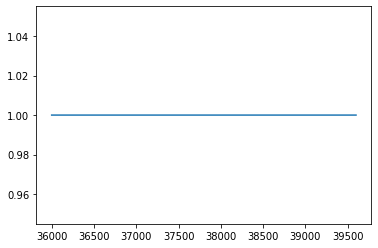

In [28]:
plt.plot(mg1._grid_status_ts[HOUR*10:HOUR*11])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

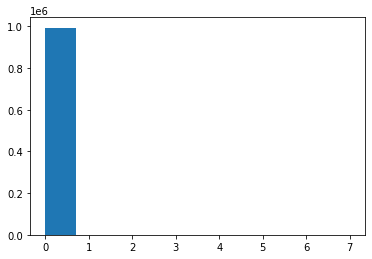

In [30]:
trained_agent = training_Q_Learning(mg=mg0, n_episodes=2, nb_actions=8, horizon = HOUR*11)
plt.hist(trained_agent.replay_buffer.actions)
# plt.plot(cost)
plt.show

In [ ]:
t2 = trained_agent

In [ ]:
li,flow,fly = mg0.ss.unpack()

In [ ]:
print(fly.power)

25036.176666666666
